# QAOA with Amazon Braket Hybrid Jobs and PennyLane

In this tutorial, we use PennyLane within Amazon Braket Hybrid Jobs to run the Quantum Approximate Optimization Algorithm (QAOA) on a Max-Cut problem.

## Learning outcomes
* Use pre-built PennyLane containers in Braket Jobs
* Set QAOA hyperparameters 
* Choose PennyLane backend (TensorFlow, PyTorch, Base)
* Use checkpoints for Braket Jobs

## QAOA background 

QAOA is a variational algorithm that uses parameterized quantum circuits to evaluate a classical cost function given by a binary optimization problem; the circuit parameters are iteratively adjusted to minimize the cost function. The QAOA algorithm itself has different settings, such as circuit depth ($p$). In analogy to machine learning, these input settings are commonly referred to as _hyperparameters_. In the following, we show how to setup the problem, prepare input data and run QAOA using Braket Jobs.

For more information about QAOA and PennyLane, see [this example notebook](../pennylane/2_Graph_optimization_with_QAOA.ipynb) or [this PennyLane tutorial](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html).

## Problem setup

A Max Cut problem is the problem to find a cut in a graph that maximizes the number of edges between the two parts after the cut. It has applications in theoretical physics and in combinatorial optimizations. To get started, we first create and visualize a random graph for the Max-Cut problem with <code>networkx</code> package. Feel free to adjust the number of nodes, <code>n</code>, and number of edges, <code>m</code> as part of your experiments.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx

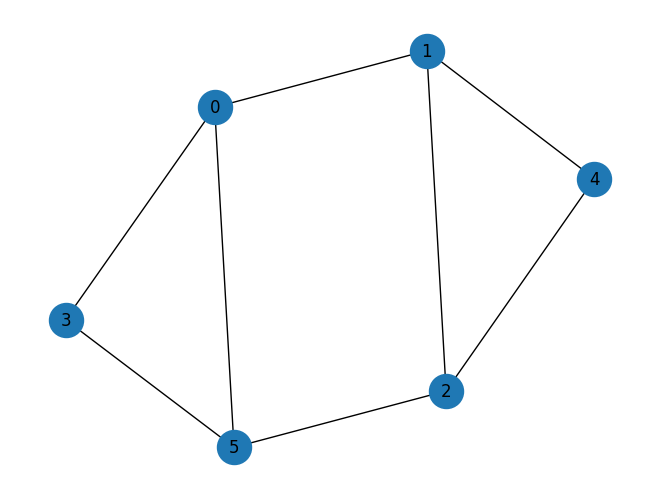

In [2]:
# We generate a random graph with num_nodes nodes and num_edges edges to run Max Cut on.
# num_nodes is the number of nodes in your graph, each represented by one qubit.
# Caution: Circuit runtimes will scale exponentially with num_nodes
num_nodes = 6
num_edges = 8
seed = 1967

graph = nx.gnm_random_graph(num_nodes, num_edges, seed=seed)

# Draw the graph
positions = nx.spring_layout(graph, seed=seed)
nx.draw(graph, with_labels=True, pos=positions, node_size=600)

## Prepare input data
We will prepare the optimization problem we want to solve, represented by the so-called Ising matrix, as the input data for the Braket Job. This best practice helps us decouple our problem definition from our algorithm code. If we want to solve another instance of this problem type, all we need to do is to point a new job to the new input data. The input data can be specified by either a path to a local file, or an Amazon S3 path that points to the data. For this example, we will create a file in the local directory encoding the problem graph.

In [3]:
input_file_path = "input-data.adjlist"
nx.write_adjlist(graph, input_file_path)

## Define the circuit

In [4]:
from pennylane import qaoa

p = 2
wires = range(num_nodes)
params = np.random.rand(2, p)

cost_h, mixer_h = qaoa.maxcut(graph)

dev = qml.device("default.qubit", wires=len(wires))


# Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)


# Repeatedly applies layers of the QAOA ansatz
def circuit(params, **kwargs):
    p = params.shape[1]
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, p, params[0], params[1])

We can visualize the circuit with the built-in PennyLane drawing function

In [5]:
circuit(params)

(<Figure size 800x700 with 1 Axes>, <Axes: >)

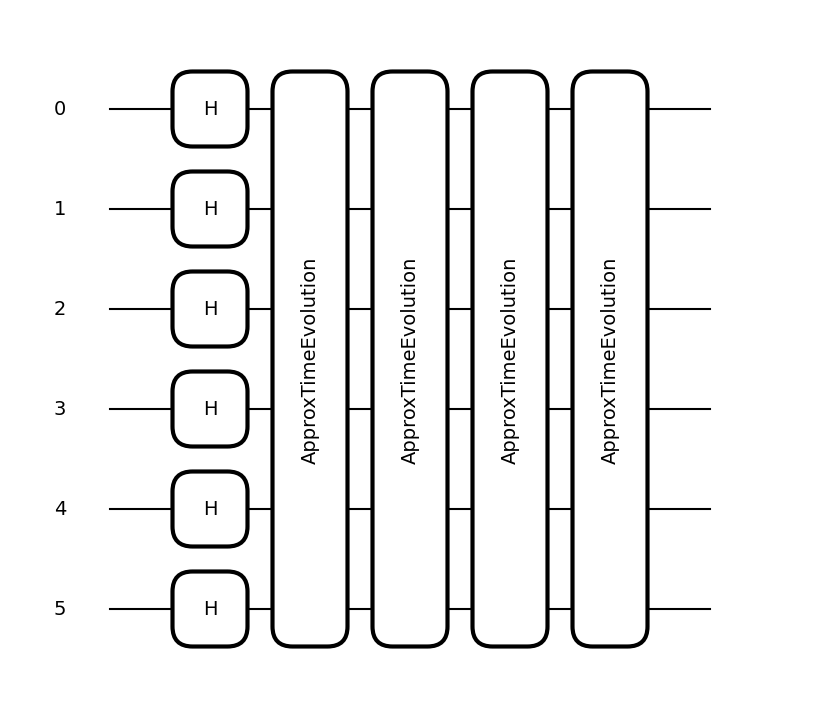

In [6]:
qml.draw_mpl(circuit)(params)

## Optimization with gradient descent

When solving the Max-Cut problem with QAOA, an optimizer updates the parameters in a parametrized circuit to minimize the cost function. While the parameters are updated in every iteration, the parametrized circuit is the same throughout the optimization process. In such a use case, parametric compilation can increase the performance of the hybrid algorithm by skipping recompilation compilation of the same circuit.  

In [7]:
from braket.jobs.metrics import log_metric
from braket.jobs import get_results_dir


def run_qaoa(p=1, steps=10):
    graph = nx.read_adjlist("input-data.adjlist", nodetype=int)
    wires = list(graph.nodes)

    cost_h, mixer_h = qaoa.maxcut(graph)
    params = np.random.rand(2, p)

    @qml.qnode(dev)
    def cost_function(params):
        circuit(params)
        return qml.expval(cost_h)

    # training loop
    optimizer = qml.GradientDescentOptimizer()
    for i in range(steps):
        params = optimizer.step(cost_function, params)

        log_metric(metric_name="loss", value=cost_function(params), iteration_number=i)

    np.save(get_results_dir() + "/optimal_params.npy", params)

    return cost_function(params)

In [8]:
run_qaoa(p=1, steps=10)

Metrics - timestamp=1697034610.534578; loss=-3.5532539476792837; iteration_number=0;
Metrics - timestamp=1697034610.5842817; loss=-3.977169221166082; iteration_number=1;
Metrics - timestamp=1697034610.6312566; loss=-4.371765205372308; iteration_number=2;
Metrics - timestamp=1697034610.6785405; loss=-4.693827751475553; iteration_number=3;
Metrics - timestamp=1697034610.7283404; loss=-4.926545034346814; iteration_number=4;
Metrics - timestamp=1697034610.7762818; loss=-5.078751429829651; iteration_number=5;
Metrics - timestamp=1697034610.8235087; loss=-5.171309307464297; iteration_number=6;
Metrics - timestamp=1697034610.9892924; loss=-5.224925506074193; iteration_number=7;
Metrics - timestamp=1697034611.036812; loss=-5.255053650930963; iteration_number=8;
Metrics - timestamp=1697034611.0840561; loss=-5.271676098898268; iteration_number=9;


tensor(-5.2716761, requires_grad=True)

## Run as a hybrid job

Great! Now let's run it on AWS. We simply annotate the function with `@hybrid_job`. We also supply the input data set, in this case the graph information. For more information of hybrid jobs see the [documentation](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs.html). 

Note that creating hybrid jobs is only supported on Python 3.10. For other versions, you may use [scripts](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs.html) or a [custom container image](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-byoc.html).

### Parametric compilation on QPUs
When using PennyLane with Braket devices, the `parametrize_differentiable` keyword argument of qml.device defines how the parameters are handled. If `parametrize_differentiable`` is True, the circuits are parametrized for the differentiable parameters. When running hybrid job on a supported QPU, Braket will compile the circuit once, without the need to recompile for subsequent parameter updates to the same circuit, resulting in faster runtimes. The speedup depends on the complexity of the circuit. Generally, the speedup is higher for more complex circuits because the saving is higher in avoiding expensive recompilation. To learn more about parametric circuits, you can read the Amazon Braket developer guide.


## Checkpoints

It is best practice to regularly save interim progress of your hybrid job as checkpoints. If your hybrid job terminates unexpectedly, for instance, if a QPU becomes unavailable, you can create a new hybrid job and load its training progress from a checkpoint. To save checkpoints, the algorithm script should contain code like the following:

```
# Training code omitted ...
# ...
save_job_checkpoint(
    checkpoint_data={
        "iteration": i,
        "params": np_params.tolist(),
        "cost": cost,
    },
)
```

This code creates and overwrites a checkpoint file `<jobname>.json` in your Hybrid Job artifacts under a subfolder checkpoints. 
To load from a checkpoint at the start of a new hybrid, the algorithm  should contain code like this:

```
checkpoint = load_job_checkpoint(job_arn)
start_iteration = checkpoint["iteration"]
params = checkpoint["params"]
```

Now we are ready to turn the entire QAOA training algorithm into a hybrid job. 

In [1]:
from braket.jobs import hybrid_job, save_job_checkpoint
from braket.tracking import Tracker


input_data_path = "input-data.adjlist"


@hybrid_job(device=None, input_data=input_data_path)
def run_qaoa_hybrid_job(p=1, steps=10):
    braket_task_tracker = Tracker()

    graph = nx.read_adjlist(input_data_path, nodetype=int)
    wires = list(graph.nodes)

    cost_h, mixer_h = qaoa.maxcut(graph)
    params = np.random.rand(2, p)

    dev = qml.device("default.qubit", wires=len(wires))

    @qml.qnode(dev)
    def cost_function(params):
        circuit(params)
        return qml.expval(cost_h)

    # training loop
    optimizer = qml.GradientDescentOptimizer()
    for i in range(steps):
        params = optimizer.step(cost_function, params)
        cost = cost_function(params)
        
        log_metric(metric_name="loss", value=cost, iteration_number=i)

        # save checkpoint data
        save_job_checkpoint(checkpoint_data={
            "iteration": i,
            "params": np_params.tolist(),
            "cost": cost,
        })

        # save any additional data
        np.save("current_params.npy", params)


    np.save("optimal_params.npy", params)

    return {
        "params": params,
        "cost": cost,
        "task summary": braket_task_tracker.quantum_tasks_statistics(),
        "estimated cost": braket_task_tracker.qpu_tasks_cost()
        + braket_task_tracker.simulator_tasks_cost(),
    }

In [10]:
%%time

job = run_qaoa_hybrid_job(p=1, steps=10)
print(job)

AwsQuantumJob('arn':'arn:aws:braket:us-west-1:961591465522:job/run-qaoa-hybrid-job-1697034611125')
CPU times: user 257 ms, sys: 9.93 ms, total: 267 ms
Wall time: 9.46 s


We see the default name of the hybrid job is the function name.

In [11]:
job.name

'run-qaoa-hybrid-job-1697034611125'

We also record the hybrid job ARN for resuming with checkpoints in the next section. 

In [ ]:
previous_job_arn = job.arn

We can check if the job has started running with:

In [12]:
job.state()

'QUEUED'

## View results

After the job is completed, we can view the result and the metrics.

In [13]:
%%time
print(job.result())

{'params': tensor([[0.31874944],
        [1.12927461]], requires_grad=True), 'cost': tensor(-4.95940047, requires_grad=True), 'task summary': {}, 'estimated cost': Decimal('0')}
CPU times: user 143 ms, sys: 15.9 ms, total: 159 ms
Wall time: 3min 17s


In [18]:
# May need to wait a bit before metrics show up
# If metrics aren't there, run a bit later
print(job.metrics())

{'timestamp': [1697034736.712305, 1697034736.7688105, 1697034736.8257906, 1697034736.8816442, 1697034736.9372487, 1697034736.9926417, 1697034737.048401, 1697034737.1044142, 1697034737.161432, 1697034737.2175596], 'loss': [-4.314447377216931, -4.377871243294846, -4.448081548458491, -4.5236092987935805, -4.602357267067748, -4.681801204142922, -4.759310374335188, -4.832508789912022, -4.8995748681030085, -4.959400471514192], 'iteration_number': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]}


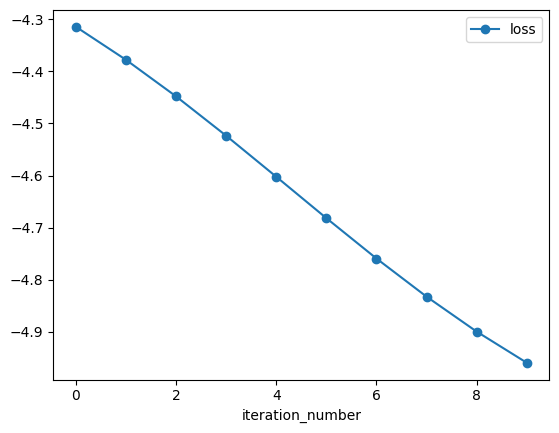

In [19]:
# A demonstration of plotting the metrics
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


df = pd.DataFrame(job.metrics())

ax = plt.figure().gca()
figure = df.plot(x="iteration_number", y="loss", ax=ax, marker="o")

In [20]:
print("Task Summary")
print(job.result()["task summary"])
print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2)."
)
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")

Task Summary


{}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 0 USD


## Continuing from previous a hybrid job with checkpoints

It is best practice to regularly save interim progress of your job as checkpoints or files.
If your job terminates unexpectedly, for instance, if a QPU becomes unavailable, you can create a new job and load its training progress from a file.


This next hybrid job adds an additional 20 steps to the QAOA training.

In [21]:
from braket.jobs import hybrid_job, save_job_checkpoint, load_job_checkpoint
from braket.tracking import Tracker


input_data_path = "input-data.adjlist"
last_params = "optimal_params.npy"


@hybrid_job(device=None, input_data={"graph": input_data_path, "last_params": last_params})
def continued_run_qaoa_hybrid_job(p=1, steps=10):

    # Resume from last checkpoint
    checkpoint = load_job_checkpoint(previous_job_arn)

    start_iteration = checkpoint["iteration"]
    params = inp.array(checkpoint["params"])
    cost = inp.array(checkpoint["cost"])

    # code below is similar for both hybrid jobs
    braket_task_tracker = Tracker()

    graph = nx.read_adjlist(input_data_path, nodetype=int)
    wires = list(graph.nodes)

    cost_h, mixer_h = qaoa.maxcut(graph)

    dev = qml.device("default.qubit", wires=len(wires))

    @qml.qnode(dev)
    def cost_function(params):
        circuit(params)
        return qml.expval(cost_h)

    # training loop
    optimizer = qml.GradientDescentOptimizer()
    for i in range(start_iteration, steps):  # start from checkpoint
        params = optimizer.step(cost_function, params)
        cost = cost_function(params)

        log_metric(metric_name="loss", value=cost, iteration_number=i)

    np.save("continued_optimal_params.npy", params)

    return {
        "params": params,
        "cost": cost,
        "task summary": braket_task_tracker.quantum_tasks_statistics(),
        "estimated cost": braket_task_tracker.qpu_tasks_cost()
        + braket_task_tracker.simulator_tasks_cost(),
    }

In [22]:
continued_job = continued_run_qaoa_hybrid_job(p=1, steps=20)
print(continued_job)

AwsQuantumJob('arn':'arn:aws:braket:us-west-1:961591465522:job/continued-run-qaoa-hybrid-job-1697034936308')


In [25]:
%%time

continued_result = continued_job.result()

CPU times: user 91.8 ms, sys: 59 µs, total: 91.8 ms
Wall time: 1.63 s


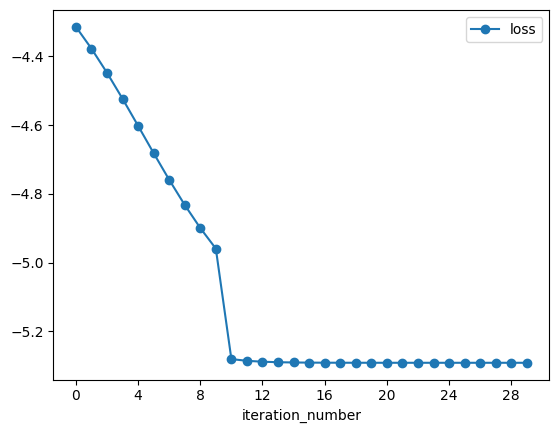

In [28]:
df = pd.DataFrame(job.metrics())
continued_df = pd.DataFrame(continued_job.metrics())
continued_df["iteration_number"] += 10

df = pd.concat([df, continued_df], ignore_index=True).sort_values("iteration_number")
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
figure = df.plot(x="iteration_number", y="loss", ax=ax, marker="o")

We see how adding 20 more iterations has improve the convergence significantly. 

In [27]:
print("Task Summary")
print(continued_job.result()["task summary"])
print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2)."
)
print(f"Estimated cost to run tasks in this job: {continued_job.result()['estimated cost']} USD")

Task Summary
{}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 0 USD


## Summary

In this tutorial, we set up a Max-Cut problem with a random graph using PennyLane. We saved the graph to a local file and provided it as input data to our Braket Job, and used the pre-built PennyLane container image to run it. Variables that are required for the training process and the optimizer are passed as hyperparameters. The result is retrieved after the QAOA algorithm is completed. Lastly, we demonstrated how to use checkpoints to save and load training progress of a job.